In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
InfDF = pd.read_csv("~/cbs-covid/src/data/COVID-19_ziekenhuisopnames.csv", delimiter=';')
 # filter data till august 2021, so it matches the data available when the paper was published
InfDF = InfDF[(InfDF['Date_of_statistics'] < '2021-08-01')]
Loc = np.array(InfDF.Municipality_code)
cleanedList = [x for x in range(len(Loc)) if str(Loc[x]) != 'nan']
print(f"{len(Loc) - len(cleanedList)} out of {len(Loc)} were nan values, and thus removed from Loc")
InfDF = InfDF[InfDF.index.isin(cleanedList)]
InfDF = InfDF.reset_index(drop=True)
Loc = np.array(InfDF.Municipality_name)
InfDF

521 out of 179745 were nan values, and thus removed from Loc


,Version,Date_of_report,Date_of_statistics,Municipality_code,Municipality_name,Security_region_code,Security_region_name,Hospital_admission_notification,Hospital_admission
0,3,2022-08-18 00:30:00,2020-02-27,GM0014,Groningen,VR01,Groningen,0,0
1,3,2022-08-18 00:30:00,2020-02-27,GM0034,Almere,VR25,Flevoland,0,0
2,3,2022-08-18 00:30:00,2020-02-27,GM0037,Stadskanaal,VR01,Groningen,0,0
3,3,2022-08-18 00:30:00,2020-02-27,GM0047,Veendam,VR01,Groningen,0,0
4,3,2022-08-18 00:30:00,2020-02-27,GM0050,Zeewolde,VR25,Flevoland,0,0
...,...,...,...,...,...,...,...,...,...
179219,3,2022-08-18 00:30:00,2021-07-31,GM1978,Molenlanden,VR18,Zuid-Holland-Zuid,0,0
179220,3,2022-08-18 00:30:00,2021-07-31,GM1979,Eemsdelta,VR01,Groningen,0,0
179221,3,2022-08-18 00:30:00,2021-07-31,GM1980,Dijk en Waard,VR10,Noord-Holland-Noord,0,0
179222,3,2022-08-18 00:30:00,2021-07-31,GM1982,Land van Cuijk,VR21,Brabant-Noord,0,1


In [3]:
Day = np.array(pd.to_datetime(InfDF.Date_of_statistics
                              ).dt.day)
Month = np.array(pd.to_datetime(InfDF.Date_of_statistics
                                ).dt.month)
Year = np.array(pd.to_datetime(InfDF.Date_of_statistics
                               ).dt.year)-2020

In [4]:
Day

array([27, 27, 27, ..., 31, 31, 31])

In [5]:
mondays = np.array([0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30,
                    31, 31, 28, 31, 30, 31, 30, 31])
cumdays = np.cumsum(mondays)
cumdays

array([  0,  31,  60,  91, 121, 152, 182, 213, 244, 274, 305, 335, 366,
       397, 425, 456, 486, 517, 547, 578])

In [6]:
# Days is the Nth day of the year. The first date in the data is 27/02/2020, which is the 58th day of 2020
Days = Day+np.array(cumdays)[Month-1+12*Year]
# The indices of the data df from 27/02 to 14/03
Index_f1_adj = np.where(Days <= 31+29+0+14) # up to (excl.) 1th Mar (+ 2 week lag)
I_hos = np.array(InfDF.Hospital_admission)
F1_loc = Loc[Index_f1_adj]
F1_hos = I_hos[Index_f1_adj]
F1_i = I_hos[Index_f1_adj]/0.01851547


In [18]:
len(F1_i)

5848

In [21]:
sum(F1_loc == 'Altena')

17

In [52]:
print(f"There were {sum(F1_hos)} people hospitalized between 27/02/2020 and 14/03/2020")

There were 437 people hospitalized between 27/02/2020 and 14/03/2020


In [53]:
print(f"There were on estimate {sum(F1_i)} people infected between 27/02/2020 and 14/03/2020")

There were on estimate 23601.88534236508 people infected between 27/02/2020 and 14/03/2020


In [14]:
# number of days of hospitalization data considered for initial infected estimation (from 27/02 <-> 14/03 = 17 days)
num_municipalities_in_2020 = 344
f1_num_days = len(Index_f1_adj[0]) / num_municipalities_in_2020
f1_num_days

17.0

In [13]:
UniLocs = np.array(pd.read_csv("~/cbs-covid/src/data/Gemeenten2018.csv")["Gemeentenaam"])
len(UniLocs)

380

In [38]:
InitialI = np.zeros(len(UniLocs))
for i in range(len(UniLocs)):
    l = UniLocs[i]
    w = np.where(F1_loc == l)[0]
    if len(w) > 0:
        InitialI[i] = np.nansum(F1_i[w])
    else:
        if l in ['Aalburg', 'Werkendam', 'Woudrichem']:
            InitialI[i] = np.nansum(F1_i[F1_loc == 'Altena'])/3
        elif l in ['Dongeradeel', 'Ferwerderadiel', 'Kollumerland en Nieuwkruisland']:
            InitialI[i] = np.nansum(F1_i[F1_loc == 'Noardeast-Fryslân'])/3
        elif l in ['Geldermalsen', 'Lingewaal', 'Neerijnen']:
            InitialI[i] = np.nansum(F1_i[F1_loc == 'West Betuwe'])/3
        elif l in ['Groningen', 'Haren', 'Ten Boer']:
            InitialI[i] = np.nansum(F1_i[F1_loc == 'Groningen'])/3
        elif l in ['Bedum', 'De Marne', 'Eemsmond', 'Winsum']:
            InitialI[i] = np.nansum(F1_i[F1_loc == 'Het Hogeland'])/4
        elif l in ['Grootegast', 'Leek', 'Marum', 'Zuidhorn']:
            InitialI[i] = np.nansum(F1_i[F1_loc == 'Westerkwartier'])/4
        elif l in ['Nuth', 'Onderbanken', 'Schinnen']:
            InitialI[i] = np.nansum(F1_i[F1_loc == 'Beekdaelen'])/3
        elif l in ['Haarlemmerliede en Spaarnwoude', 'Haarlemmermeer']:
            InitialI[i] = np.nansum(F1_i[F1_loc == 'Haarlemmermeer'])/2
        elif l in ['Leerdam', 'Zederik', 'Vianen']:
            InitialI[i] = np.nansum(F1_i[F1_loc == 'Vijfheerenlande'])/3
        elif l in ['Binnenmaas', 'Cromstrijen', 'Korendijk', 'Oud-Beijerland', 'Strijen']:
            InitialI[i] = np.nansum(F1_i[F1_loc == 'Hoeksche Waard'])/5
        elif l in ['Giessenlanden', 'Molenwaard']:
            InitialI[i] = np.nansum(F1_i[F1_loc == 'Molenlanden'])/2
        elif l in ['Noordwijk', 'Noordwijkerhout']:
            InitialI[i] = np.nansum(F1_i[F1_loc == 'Noordwijk'])/2
        elif l in ['Appingedam', 'Delfzijl', 'Loppersum']:
            InitialI[i] = np.nansum(F1_i[F1_loc == 'Eemsdelta'])/3
        elif l in ['Sdwest-Frysln']:
            InitialI[i] = np.nansum(F1_i[F1_loc == 'S\x9cdwest-Frysl\x89n'])
        elif l in ['Hengelo']:
            InitialI[i] = np.nansum(F1_i[F1_loc == 'Hengelo (O.)'])
        elif l in ['Haaren', 'Oisterwijk']:
            InitialI[i] = np.nansum(F1_i[F1_loc == 'Oisterwijk'])/2
# InitialI = np.round(InitialI/100).astype(int) # divide by resolution (people per agent)
InitialI = np.round(InitialI).astype(int) # divide by resolution (people per agent)


In [39]:
# The estimated initial infected per municipality per day before phase 1
initial_infected_per_day = np.zeros(int(len(UniLocs) * f1_num_days))
for i in range(len(UniLocs)):
    l = UniLocs[i]
    w = np.where(F1_loc == l)[0]
    if len(w) > 0:
        initial_infected_per_day[w] = F1_i[w]
    else:
        if l in ['Aalburg', 'Werkendam', 'Woudrichem']:
            w = np.where(F1_loc == 'Altena')
            initial_infected_per_day[w] = (F1_i[w])/3
        elif l in ['Dongeradeel', 'Ferwerderadiel', 'Kollumerland en Nieuwkruisland']:
            w = np.where(F1_loc == 'Noardeast-Fryslân')
            initial_infected_per_day[w] = (F1_i[w])/3
        elif l in ['Geldermalsen', 'Lingewaal', 'Neerijnen']:
            w = np.where(F1_loc == 'West Betuwe')
            initial_infected_per_day[w] = (F1_i[w])/3
        elif l in ['Groningen', 'Haren', 'Ten Boer']:
            w = np.where(F1_loc == 'Groningen')
            initial_infected_per_day[w] = (F1_i[w])/3
        elif l in ['Bedum', 'De Marne', 'Eemsmond', 'Winsum']:
            w = np.where(F1_loc == 'Het Hogeland')
            initial_infected_per_day[w] = (F1_i[w])/4
        elif l in ['Grootegast', 'Leek', 'Marum', 'Zuidhorn']:
            w = np.where(F1_loc == 'Westerkwartier')
            initial_infected_per_day[w] = (F1_i[w])/4
        elif l in ['Nuth', 'Onderbanken', 'Schinnen']:
            w = np.where(F1_loc == 'Beekdaelen')
            initial_infected_per_day[w] = (F1_i[w])/3
        elif l in ['Haarlemmerliede en Spaarnwoude', 'Haarlemmermeer']:
            w = np.where(F1_loc == 'Haarlemmermeer')
            initial_infected_per_day[w] = (F1_i[w])/2
        elif l in ['Leerdam', 'Zederik', 'Vianen']:
            w = np.where(F1_loc == 'Vijfheerenlande')
            initial_infected_per_day[w] = (F1_i[w])/3
        elif l in ['Binnenmaas', 'Cromstrijen', 'Korendijk', 'Oud-Beijerland', 'Strijen']:
            w = np.where(F1_loc == 'Hoeksche Waard')
            initial_infected_per_day[w] = (F1_i[w])/5
        elif l in ['Giessenlanden', 'Molenwaard']:
            w = np.where(F1_loc == 'Molenlanden')
            initial_infected_per_day[w] = (F1_i[w])/2
        elif l in ['Noordwijk', 'Noordwijkerhout']:
            w = np.where(F1_loc == 'Noordwijk')
            initial_infected_per_day[w] = (F1_i[w])/2
        elif l in ['Appingedam', 'Delfzijl', 'Loppersum']:
            w = np.where(F1_loc == 'Eemsdelta')
            initial_infected_per_day[w] = (F1_i[w])/3
        elif l in ['Sdwest-Frysln']:
            w = np.where(F1_loc == 'S\x9cdwest-Frysl\x89n')
            initial_infected_per_day[w] = (F1_i[w])
        elif l in ['Hengelo']:
            w = np.where(F1_loc == 'Hengelo (O.)')
            initial_infected_per_day[w] = (F1_i[w])
        elif l in ['Haaren', 'Oisterwijk']:
            w = np.where(F1_loc == 'Oisterwijk')
            initial_infected_per_day[w] = (F1_i[w])/2
initial_infected_per_day = np.round(initial_infected_per_day).astype(int) # divide by resolution (people per agent)


In [40]:
sum(InitialI)

22194

In [41]:
sum(initial_infected_per_day)

21305

In [42]:
initial_infected_per_day = pd.DataFrame({'Infected':initial_infected_per_day})
initial_infected_per_day.to_csv('initial_infected_per_municipality_per_day.csv', index=False)

In [55]:
mask_list_high_infected = np.where(InitialI > 1000)
mask_list_high_infected

(array([ 52, 203, 306]),)

In [ ]:
high_inf_locs = UniLocs[mask_list_high_infected]
high_inf_locs

In [14]:
initial_infected = pd.DataFrame({'Gemeentenaam':UniLocs, 'Infected':InitialI})

In [15]:
initial_infected.to_csv('initial_infected_per_municipality.csv', index=False)

In [25]:
np.sum(InitialI)

22194

Number of non-zero entries = 154
Number of infected = 22194


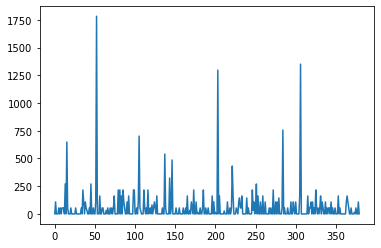

In [37]:
plt.plot(InitialI)
print("Number of non-zero entries = {}".format(len([i for i in InitialI if i != 0])))
print("Number of infected = {}".format(sum(InitialI)))

Number of non-zero entries = 142
Number of infected = 249


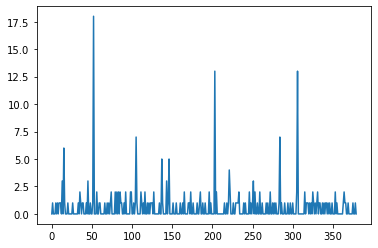

In [42]:
# if persons_per_agent is large, we lose a lot of information -> emphesis shifts to most-infected municipalities
# also: any agent that gets infected implies that `persons_per_agent` people get infected, which results in very
# sharp increases / decreases of infected / hospitalized 
persons_per_agent = 101
InitialI_reduced = [round(item/persons_per_agent) for item in InitialI]
plt.plot(InitialI_reduced)
print("Number of non-zero entries = {}".format(len([i for i in InitialI_reduced if i != 0])))
print("Number of infected = {}".format(sum(InitialI_reduced)))